# Trabalho Prático 2: Transfer Learning

Isadora Alves de Salles <br>


## Imports necessários

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython.display import display
from IPython.display import Markdown

# CNN
from keras.datasets import cifar10
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import Model

## Resumo dos Dados

O conjunto de dados usado neste trabalho é o CIFAR10,  um conjunto de imagens dividas em 10 classes. O dataset contém 50000 imagens de treino e 10000 imagens de teste, cada uma de tamanho 32x32 pixeis no formato RGB, ou seja, possuindo 3 canais de cor. Cada imagem possui um target associado, que pode ser "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck".

In [614]:
# Carrega as imagens ja separadas entre treino e teste. 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


# Pega o tamanho das imagens 
img_shape = x_train.shape[1:]
print("Tamanho da imagem: {}".format(img_shape))


Tamanho da imagem: (32, 32, 3)


### Exemplo de Imagens

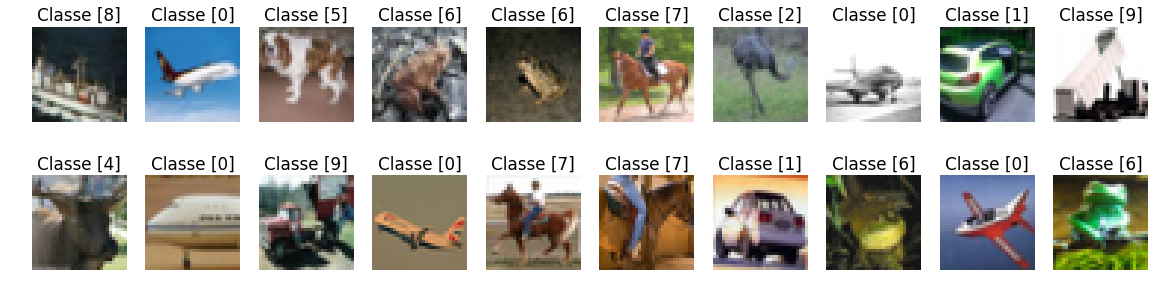

In [616]:
n_rows = 2
n_cols = 10
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5))

for i in range(n_rows):
    for j in range(n_cols):
        img_i = np.random.randint(0, x_train.shape[0])
        axes[i][j].imshow(x_train[img_i], cmap="gray")
        axes[i][j].set_title("Classe {}".format(y_train[img_i]))
        axes[i][j].axis("off")
plt.show()

## Preprocessamento

Normalização da intensidade dos pixels.

In [0]:
# Normaliza a intensidade dos pixels para o intervalo [0, 1]
x_train = x_train/255
x_test = x_test/255

Devemos transpor o array do y_train e y_test para que seja possível utilizar "get_dumines" posteriormente.

In [0]:
# array de labels
y_train = y_train[:, 0]
y_test = y_test[:, 0]

Definição dos elementos de cada classe.

In [0]:
classesA = [0, 1, 2, 4, 6, 7, 8, 9]
classesB = [3, 5]

Separação das imagens de cada conjunto, A e B. Sendo que B conterá as imagens da classe 5 e 3 pois são os últimos dois dígitos da minha matrícula.

In [0]:
# separa as imagens das classes 3 e 5 para a parte B e o restante para a parte A
train_filter = np.where((y_train == 5 ) | (y_train == 3))
test_filter = np.where((y_test == 5) | (y_test == 3))
train_mask = np.where(np.isin(y_train, [0, 1, 2, 4, 6, 7, 8, 9]))
test_mask = np.where(np.isin(y_test, [0, 1, 2, 4, 6, 7, 8, 9]))

# 3 e 5 na parte B
X_trainB, Y_trainB = x_train[train_filter[0]], y_train[train_filter[0]]  
X_testB, Y_testB = x_test[test_filter[0]], y_test[test_filter[0]]

# 1, 2, 4, 6, 7, 8, 9 na parte A
X_trainA, Y_trainA = x_train[train_mask[0]], y_train[train_mask[0]]
X_testA, Y_testA = x_test[test_mask[0]], y_test[test_mask[0]]


One-hot encoding cria novas colunas binárias, indicando a presença de cada possível valor do dado original. Precisamos realizar isso sobre nossa target pois futuramente, utilizaremos "categorical_crossentropy" como função de perda.

In [0]:
# One-hot encoding dos targets
Y_trainB = pd.get_dummies(Y_trainB).values
Y_testB = pd.get_dummies(Y_testB).values

Y_trainA = pd.get_dummies(Y_trainA).values
Y_testA = pd.get_dummies(Y_testA).values

Exemplo do resultado do one-hot encoding.

In [440]:
Y_trainA

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

Número de classes para cada parte, A e B.

In [439]:
# Pega o número de classes de A e B
n_classesA = Y_trainA.shape[1]
n_classesB = Y_trainB.shape[1]

print("Número de classes em A: {}".format(n_classesA))
print("Número de classes em B: {}".format(n_classesB))

Número de classes em A: 8
Número de classes em B: 2


# Modelos

### Funções usadas na avaliação dos experimentos:

As duas funções a seguir foram utilizadas para avaliar os resultados gerados pelos experimentos, sendo a primeira utilizada para plotar as curvas de loss e acurácia e a segunda utilizada para plotar a matriz de confusão de cada modelo.

In [0]:
def gera_graficos(history):
  # Gera graficos do resultado do treino
  plt.rc("font", **{"size": 14})
  fig, axes = plt.subplots(1, 2, figsize=(17, 7))

  # Loss
  axes[0].plot(range(1, len(history.history["loss"])+1), history.history["loss"], 
          label="Train Loss", color="royalblue", lw=3)
  axes[0].plot(range(1, len(history.history["val_loss"])+1), history.history["val_loss"], 
          label="Test Loss", color="forestgreen", lw=3)
  axes[0].set_ylabel("Loss")
  axes[0].set_xlabel("Epoch")
  axes[0].set_xticks(range(1, len(history.history["acc"])+1))
  axes[0].legend()

  # Accuracy
  axes[1].plot(range(1, len(history.history["acc"])+1), history.history["acc"], 
          label="Train ACC", color="royalblue", lw=3)
  axes[1].plot(range(1, len(history.history["val_acc"])+1), history.history["val_acc"], 
          label="Test ACC", color="forestgreen", lw=3)
  axes[1].set_ylabel("Accuracy")
  axes[1].set_xlabel("Epoch")
  axes[1].set_xticks(range(1, len(history.history["acc"])+1))
  axes[1].legend()
  plt.show()

In [0]:
def matriz_confusao(model, y_test, x_test, classes):
  # Matriz de Confusao

  # Predições
  y_proba = model.predict(x_test)
  y_pred = np.argmax(y_proba, axis=1)

  # Labels (desfaz o one-hot encode)
  y_true = np.argmax(y_test, axis=1)

  cm = metrics.confusion_matrix(y_true, y_pred)
  #classes = list(range(1, 11))
  
  fig, ax = plt.subplots(figsize=(7, 7))
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  ax.figure.colorbar(im, ax=ax)
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         xticklabels=classes, yticklabels=classes,
         title="Matriz de Confusão",
         ylabel="Real",
         xlabel="Predito")

  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], "d"),
                  ha="center", va="center",
                  color="white" if cm[i, j] > cm.max()/2. else "black")
  fig.tight_layout()
  plt.show()

# Parte A

Na parte A era necessário criar uma rede convolucional seguindo as especificações de quantidade de camadas exigida, e rodar para as 8 classes.


In [684]:
modelA = Sequential()
modelA.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", name="Conv1", input_shape=img_shape))
modelA.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", name="Conv2"))
modelA.add(MaxPooling2D(pool_size=(2, 2), name="Pool1"))
modelA.add(Dropout(0.5, name="Dropout1"))

modelA.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv3", input_shape=img_shape))
modelA.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv4"))
modelA.add(MaxPooling2D(pool_size=(2, 2), name="Pool2"))
modelA.add(Dropout(0.5, name="Dropout2"))

modelA.add(Flatten(name="Flatten"))
modelA.add(Dense(128, activation="relu", name="Dense1"))
modelA.add(Dropout(0.5, name="Dropout3"))
modelA.add(Dense(n_classesA, activation='softmax', name="Output"))

#resumo do modelo
modelA.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 32)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 16, 16, 32)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
Conv4 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
__________

Para escolher o otimizar foram testados o Adam, SGD, e rmsprop, além de variar a taxa de aprendizado, até encontrar o que retornasse um melhor resultado, que nesse caso foi o Adam com taxa 0.001.

In [0]:
opt = optimizers.Adam(lr=0.001)
modelA.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [686]:
history = modelA.fit(X_trainA, Y_trainA, batch_size=128, epochs=20, validation_data=(X_testA, Y_testA))

Train on 40000 samples, validate on 8000 samples
Epoch 1/20
40000/40000 [==============================] - 26s 650us/step - loss: 1.5597 - acc: 0.3999 - val_loss: 1.1945 - val_acc: 0.5397
Epoch 2/20
40000/40000 [==============================] - 7s 163us/step - loss: 1.2109 - acc: 0.5460 - val_loss: 1.0061 - val_acc: 0.6265
Epoch 3/20
40000/40000 [==============================] - 6s 162us/step - loss: 1.0589 - acc: 0.6093 - val_loss: 0.8553 - val_acc: 0.6926
Epoch 4/20
40000/40000 [==============================] - 7s 163us/step - loss: 0.9511 - acc: 0.6564 - val_loss: 0.7660 - val_acc: 0.7151
Epoch 5/20
40000/40000 [==============================] - 6s 162us/step - loss: 0.8681 - acc: 0.6875 - val_loss: 0.7200 - val_acc: 0.7345
Epoch 6/20
40000/40000 [==============================] - 7s 163us/step - loss: 0.8200 - acc: 0.7063 - val_loss: 0.6478 - val_acc: 0.7674
Epoch 7/20
40000/40000 [==============================] - 6s 162us/step - loss: 0.7680 - acc: 0.7258 - val_loss: 0.6212 - 

Como podemos ver nos gráficos a seguir o erro no treino foi minimizado, tão pouco não ocorreu overfitting, ou seja, a acurácia de treino não continuou crescendo enquanto a de validação caiu. Isso foi possível pelo uso de regularizador, que nesse caso foi a camada de Dropout, que irá randomicamente selecionar neurônios que serão ignorados durante o treino, isso significa que teremos uma diminuição dos parâmentros que contribuirão para a ativação da última camada.



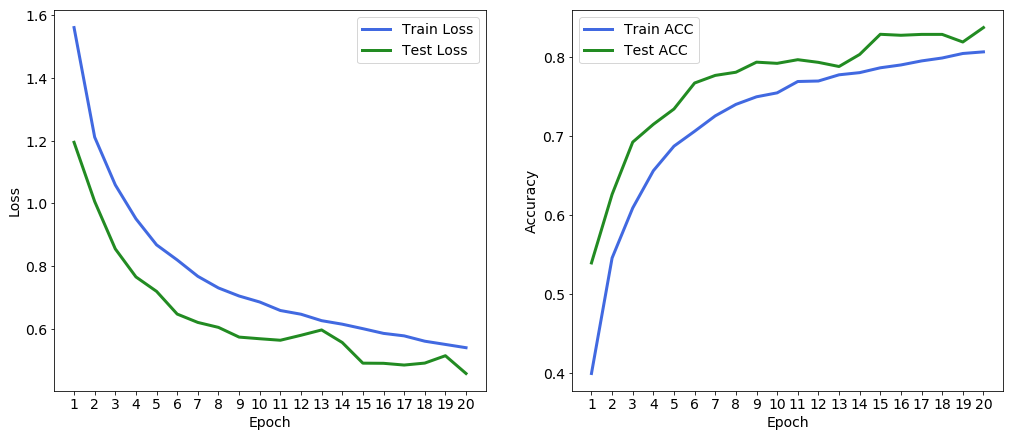

In [687]:
gera_graficos(history)

Com a matriz de confusão podemos interpretar as outras métricas além da acurácia, como precisão e revocação. Como foi visto acima, a acurácia do modelo é alta, e isso pode ser visto na matriz de confusão quando percebemos que há poucos falsos positivos e falsos negativos em relação à quantidade de verdadeiros positivos e de verdadeiros negativos, para todas as classes. 

Há uma confusão maior entre as classes 2, 4 e 6, que representam respectivamente "bird", "deer" e  "frog", a classe 2 é predita como 4 ou 6 em alguns casos, e acredito que isso pode ocorrer devido ao fato de que o fundo dessas imagens podem ser muito parecidos em alguns casos, fazendo com que alguns dos padrões encontrados pela rede sejam similares ao da outra classe.

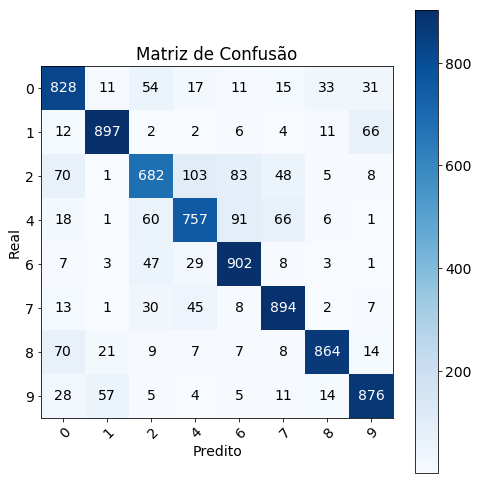

In [688]:
matriz_confusao(modelA, Y_testA, X_testA, classesA)

# Parte B

## Sem transfer learning

Nesta etapa foi especificado para que treinassemos a rede do zero, inicializando os pesos aleatóriamente usando a mesma arquitetura da CNN treinada anteriormente.<br>

Abaixo um novo modelo foi criado, seguindo a mesma arquitetura anterior e o chamaremos de modelB.

In [569]:
modelB = Sequential()
modelB.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", name="Conv1", input_shape=img_shape))
modelB.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", name="Conv2"))
modelB.add(MaxPooling2D(pool_size=(2, 2), name="Pool1"))
modelB.add(Dropout(0.5, name="Dropout1"))

modelB.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv3", input_shape=img_shape))
modelB.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", name="Conv4"))
modelB.add(MaxPooling2D(pool_size=(2, 2), name="Pool2"))
modelB.add(Dropout(0.5, name="Dropout2"))

modelB.add(Flatten(name="Flatten"))
modelB.add(Dense(128, activation="relu", name="Dense1"))
modelB.add(Dropout(0.5, name="Dropout3"))
modelB.add(Dense(n_classesB, activation='softmax', name="Output"))

#resumo do modelo
modelB.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 32)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 16, 16, 32)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
Conv4 (Conv2D)               (None, 16, 16, 64)        36928     
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 8, 8, 64)          0         
__________

Também foi utilizado o mesmo otimizador e função de perda do modelo anterior.

In [0]:
opt = optimizers.Adam(lr=0.001)
modelB.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [571]:
history = modelB.fit(X_trainB, Y_trainB, batch_size=128, epochs=20, validation_data=(X_testB, Y_testB))

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 20s 2ms/step - loss: 0.6879 - acc: 0.5386 - val_loss: 0.6845 - val_acc: 0.5680
Epoch 2/20
10000/10000 [==============================] - 2s 168us/step - loss: 0.6614 - acc: 0.6006 - val_loss: 0.6547 - val_acc: 0.6165
Epoch 3/20
10000/10000 [==============================] - 2s 157us/step - loss: 0.6321 - acc: 0.6470 - val_loss: 0.6229 - val_acc: 0.6580
Epoch 4/20
10000/10000 [==============================] - 2s 160us/step - loss: 0.6129 - acc: 0.6690 - val_loss: 0.5814 - val_acc: 0.6890
Epoch 5/20
10000/10000 [==============================] - 2s 158us/step - loss: 0.5827 - acc: 0.6884 - val_loss: 0.5678 - val_acc: 0.7025
Epoch 6/20
10000/10000 [==============================] - 2s 159us/step - loss: 0.5613 - acc: 0.7109 - val_loss: 0.5433 - val_acc: 0.7190
Epoch 7/20
10000/10000 [==============================] - 2s 158us/step - loss: 0.5407 - acc: 0.7206 - val_loss: 0.5242 - va

Como podemos observar nos gráficos a seguir o erro no treino foi minimizado, mesmo que no final exista uma certa "perturbação", perceba que não é algo relevante e que deveria taxar o modelo como em estádo de overfitting, até mesmo porque no gráfico da acurácia podemos ver que a acurácia de treino e validação é extremamente próxima no final das 20 épocas. O formato do gráfico sugere que com mais épocas o erro de validação voltaria a descer. É importante mencionar também que o erro não começa tão alto, assim a escala do gráfico é bastante ampla e pode gerar a impressão de que os valores na época 20 estão muito distantes, porém não estão, como pode ser observado acima.

Novamente, como foi utilizada a mesma arquitetura anterior, a minimização do erro foi possível devido ao uso das camadas de Dropout como regularizador.

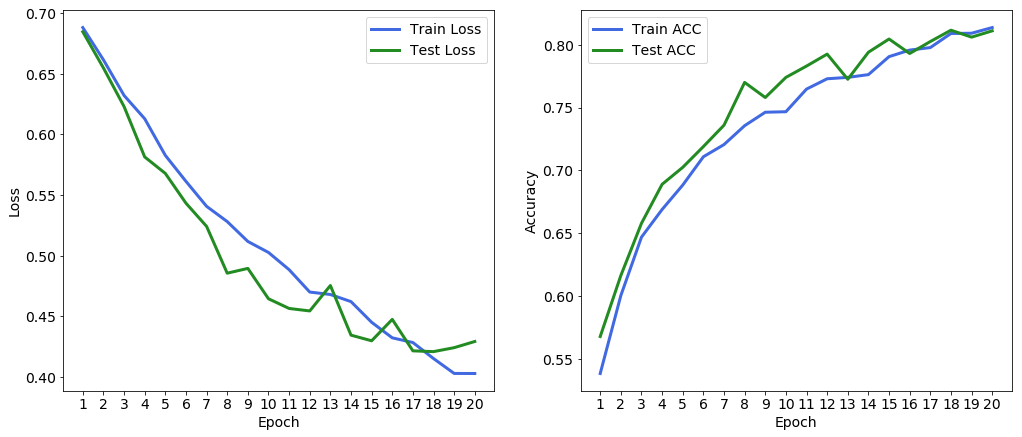

In [573]:
gera_graficos(history)

As classes 3 e 5 representam, respectivamente, "cat" e "dog", sendo assim uma certa confusão entre as duas classes já era previsto, visto que cachorro e gato são animais um tanto quanto parecidos. Na matriz de confusão abaixo temos que os gatos foram preditos mais corretamente do que os cachorros, ou seja, mais cachorros foram confundidos com gatos do que o contrário. 

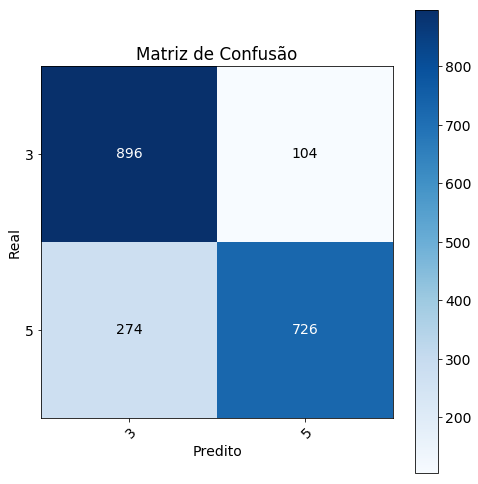

In [575]:
matriz_confusao(modelB, Y_testB, X_testB, classesB)

## Fine-Tuning em uma camada

Para essa etapa deviamos utilizar os pesos da rede treinada na parte A e realizar fine-tuning na última camada Fully Connected. Ou seja, precisamos utilizar a rede A, porém removendo a última camada e setando as restantes como para que não sejam treinadas novamente. Iremos incluir uma camada Dense no lugar da que foi excluída, e assim estaremos reaproveitando os pesos de uma rede treinada para classes distintas das que temos agora.


In [689]:
# cria a base do modelo pre treinado
base_model = modelA
base_model.pop()

x = base_model.output
predictions = Dense(2, activation='softmax', name='Dense2')(x)

# este e o modelo que vamos treinar
fineTuning = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False


fineTuning.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1_input (InputLayer)     (None, 32, 32, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 32)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 16, 16, 32)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
Conv4 (Conv2D)               (None, 16, 16, 64)        36928     
__________

In [0]:
optimizer = optimizers.Adam(lr=0.001)
fineTuning.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [691]:
history = fineTuning.fit(X_trainB, Y_trainB, batch_size=128, epochs=20, validation_data=(X_testB, Y_testB))

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 21s 2ms/step - loss: 0.8258 - acc: 0.5163 - val_loss: 0.6547 - val_acc: 0.6165
Epoch 2/20
10000/10000 [==============================] - 1s 120us/step - loss: 0.7041 - acc: 0.5777 - val_loss: 0.6244 - val_acc: 0.6510
Epoch 3/20
10000/10000 [==============================] - 1s 122us/step - loss: 0.6683 - acc: 0.6043 - val_loss: 0.6166 - val_acc: 0.6675
Epoch 4/20
10000/10000 [==============================] - 1s 119us/step - loss: 0.6451 - acc: 0.6250 - val_loss: 0.6132 - val_acc: 0.6630
Epoch 5/20
10000/10000 [==============================] - 1s 122us/step - loss: 0.6480 - acc: 0.6238 - val_loss: 0.6113 - val_acc: 0.6665
Epoch 6/20
10000/10000 [==============================] - 1s 119us/step - loss: 0.6442 - acc: 0.6239 - val_loss: 0.6130 - val_acc: 0.6730
Epoch 7/20
10000/10000 [==============================] - 1s 121us/step - loss: 0.6437 - acc: 0.6286 - val_loss: 0.6111 - va

Como pode ser visto nos gráficos a seguir o erro também foi minimizado, e não ocorreu overfitting. Porém a acurácia não foi tão alta quanto nos outros modelos vistos.

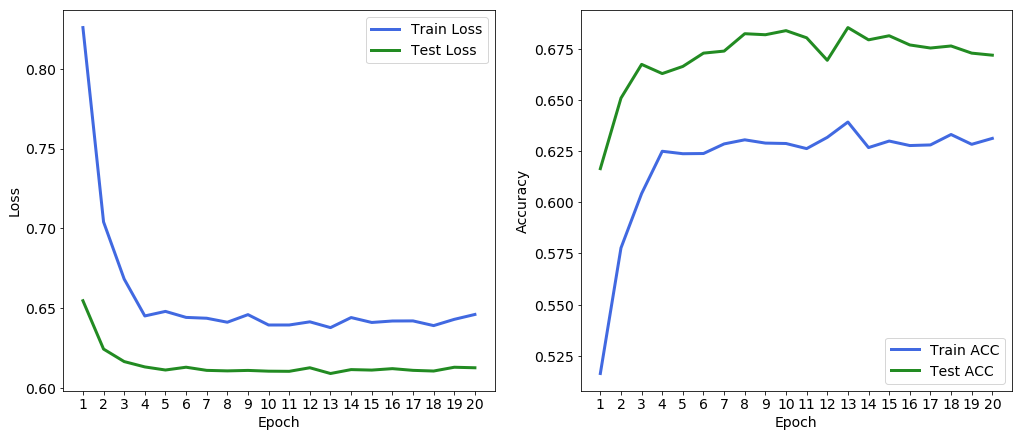

In [692]:
gera_graficos(history)

Na matriz de confusão percebemos que utilizar o fine-tuning em uma camada trouxe os piores resultados para o conjunto B, como pode ser visto temos mais falsos positivos e negativos nesta matriz do que na anterior. Isso ocorre pois a maioria dos parâmetros não foram treinados para distinguir gato e cachorro, que são as classes 3 e 5. O fine-tuning trás resultados muito significativos para datasets muito maiores, pois o tempo de treinamento é muito inferior. <br>

Novamente podemos observar que mais cachorros foram confundidos com gatos do que o contrário.

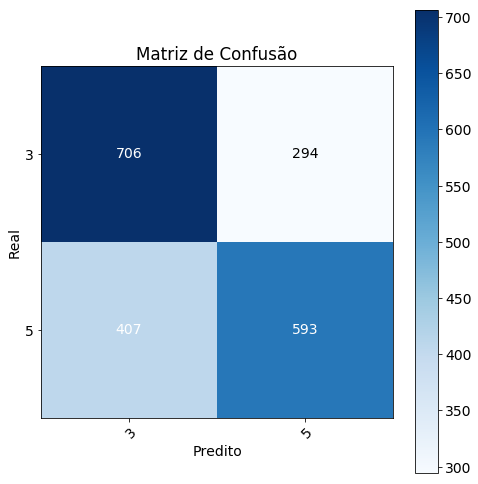

In [679]:
matriz_confusao(fineTuning, Y_testB, X_testB, classesB)

## Fine-Tuning em duas camadas

Para essa etapa deviamos utilizar os pesos da rede treinada na parte A e realizar fine-tuning nas duas última camada Fully Connected. Ou seja, precisamos utilizar a rede A, porém removendo as duas camadas Dense e setando as restantes como para que não sejam treinadas novamente. Iremos incluir duas camadas Dense no lugar da que foi excluída, e assim estaremos reaproveitando os pesos de uma rede treinada para classes distintas das que temos agora.

In [662]:
# create the base pre-trained model
base_model.pop()
base_model.pop()
base_model.trainable = False
x = base_model.output
x = Dense(128, activation='softmax', name='Dense1')(x)
x = Dropout(0.5, name='Dropout3')(x)
predictions = Dense(2, activation='softmax', name='Dense2')(x)

# this is the model we will train
fineTuning2 = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    
fineTuning2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1_input (InputLayer)     (None, 32, 32, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 16, 16, 32)        0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 16, 16, 32)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
Conv4 (Conv2D)               (None, 16, 16, 64)        36928     
__________

Novamente utilizamos o Adam com taxa de aprendizado 0.001.

In [0]:
optimizer = optimizers.Adam(lr=0.001)
fineTuning2.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [664]:
history = fineTuning2.fit(X_trainB, Y_trainB, batch_size=128, epochs=20, validation_data=(X_testB, Y_testB))

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 20s 2ms/step - loss: 0.6815 - acc: 0.6188 - val_loss: 0.6585 - val_acc: 0.6990
Epoch 2/20
10000/10000 [==============================] - 1s 125us/step - loss: 0.6436 - acc: 0.6870 - val_loss: 0.6178 - val_acc: 0.7125
Epoch 3/20
10000/10000 [==============================] - 1s 123us/step - loss: 0.6184 - acc: 0.6903 - val_loss: 0.5965 - val_acc: 0.7170
Epoch 4/20
10000/10000 [==============================] - 1s 122us/step - loss: 0.6049 - acc: 0.6982 - val_loss: 0.5825 - val_acc: 0.7220
Epoch 5/20
10000/10000 [==============================] - 1s 124us/step - loss: 0.5916 - acc: 0.7110 - val_loss: 0.5734 - val_acc: 0.7350
Epoch 6/20
10000/10000 [==============================] - 1s 125us/step - loss: 0.5872 - acc: 0.7093 - val_loss: 0.5652 - val_acc: 0.7370
Epoch 7/20
10000/10000 [==============================] - 1s 125us/step - loss: 0.5805 - acc: 0.7123 - val_loss: 0.5595 - va

O erro foi minimizado assim como não ocorreu overfitting. O treinamento ocorreu bem mais rápido do que sem usarmos o fine-tuning, o que era de se esperar, e a acurácia com o fine-tuning em 2 camadas foi superior a com o fine-tuning em uma camada. Porém, o fine-tuning com duas camadas levou um pouco mais de tempo para executar.

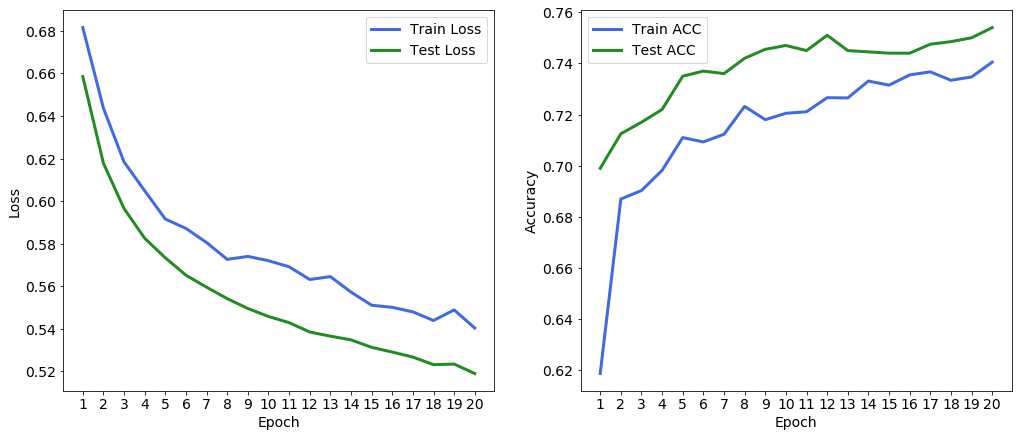

In [667]:
gera_graficos(history)

Na matriz de confusão percebemos que o fine-tuning com duas camadas foi melhor do que o fine-tuning com uma camada, possuindo menos falsos negativos e positivos. Pois tendo mais pesos para aprender com nossos dados (classes de gato e cachorro), conseguimos generalizar melhor. Porém, quando comparamos este resultado com a rede treinada do zero, observamos que tanto a acurácia quanto revocação e precisão foram superiores ao se treinar a rede do zero. Isso é esperado principalmente tendo em vista as classes analisadas que podem se confundir facilmente.

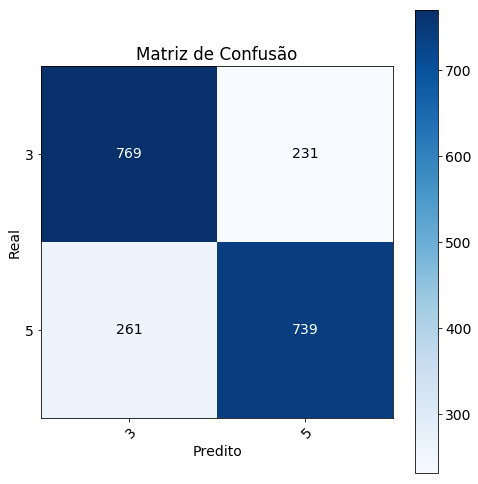

In [668]:
matriz_confusao(fineTuning2, Y_testB, X_testB, classesB)

## Conclusões gerais
Levando em conta que as classes com as quais eu trabalhei era cachorro e gato, esperava-se que houvessem erros em todos os modelos, visto que são dois animais parecidos e os modelos poderiam confundir. Sendo assim, rodar o modelo do zero com pesos inicializados aleatoriamente resultou em melhor acurácia e acerto para as minhas classes.  <br>

No que se refere a tempo de execução o fine-tuning em uma camada se saiu melhor.

As vantagens de transfer learning são: <br>

1. Não precisamos de um dataset grande.
2. Não requer muito poder computacional, visto que poucos parâmetros serão treinados. Como estamos usando pesos pre-treinados nós temos que aprender apenas os pesos das últimas camadas.